In [1]:
import tensorflow as tf
import os
import subprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
DATASET_DIR = "dataset_processed"

IMG_SIZE = (224, 224)
BATCH_SIZE = 4
EPOCHS = 200
LEARNING_RATE = 1e-4


In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4
)

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

# 🔹 VALIDATION GENERATOR
val_gen = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 1606 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


In [4]:
print("📁 Dataset info")
print("-" * 40)

print(f"Total imagens (train): {train_gen.n}")
print(f"Total imagens (val):   {val_gen.n}")
print()

print("Classes e índices:")
for cls, idx in train_gen.class_indices.items():
    print(f"  {cls}: {idx}")

print()

# Contagem por classe (treino)
import numpy as np
unique, counts = np.unique(train_gen.classes, return_counts=True)

print("Distribuição no TREINO:")
for cls, idx in train_gen.class_indices.items():
    print(f"  {cls}: {counts[idx]} imagens")


📁 Dataset info
----------------------------------------
Total imagens (train): 1606
Total imagens (val):   801

Classes e índices:
  amora: 0
  not_amora: 1

Distribuição no TREINO:
  amora: 240 imagens
  not_amora: 1366 imagens


In [5]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)


In [7]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=20,
    min_lr=1e-6
)

callbacks = [early_stop, reduce_lr]


In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200


2026-02-19 20:49:46.219647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


402/402 [==============================] - 19s 42ms/step - loss: 0.3999 - accuracy: 0.8487 - val_loss: 0.2536 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 2/200
402/402 [==============================] - 15s 37ms/step - loss: 0.2731 - accuracy: 0.8898 - val_loss: 0.1832 - val_accuracy: 0.9513 - lr: 1.0000e-04
Epoch 3/200
402/402 [==============================] - 16s 40ms/step - loss: 0.2286 - accuracy: 0.9078 - val_loss: 0.1541 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 4/200
402/402 [==============================] - 15s 36ms/step - loss: 0.2028 - accuracy: 0.9203 - val_loss: 0.1428 - val_accuracy: 0.9588 - lr: 1.0000e-04
Epoch 5/200
402/402 [==============================] - 15s 37ms/step - loss: 0.1753 - accuracy: 0.9377 - val_loss: 0.1349 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 6/200
402/402 [==============================] - 15s 37ms/step - loss: 0.1602 - accuracy: 0.9365 - val_loss: 0.1297 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 7/200
402/402 [===================

In [10]:
# Criar pasta output se não existir
os.makedirs("output", exist_ok=True)

# Salvar modelo Keras
model_path = "output/amora_model.h5"
model.save(model_path)

print("Modelo salvo em:", model_path)

# Converter automaticamente para TensorFlow.js
tfjs_output_path = "output/amora_model_tfjs"

subprocess.run([
    "tensorflowjs_converter",
    "--input_format=keras",
    model_path,
    tfjs_output_path
], check=True)

print("Modelo convertido para TensorFlow.js em:", tfjs_output_path)


/opt/anaconda3/envs/daniel/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo salvo em: output/amora_model.h5


/opt/anaconda3/envs/daniel/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Modelo convertido para TensorFlow.js em: output/amora_model_tfjs


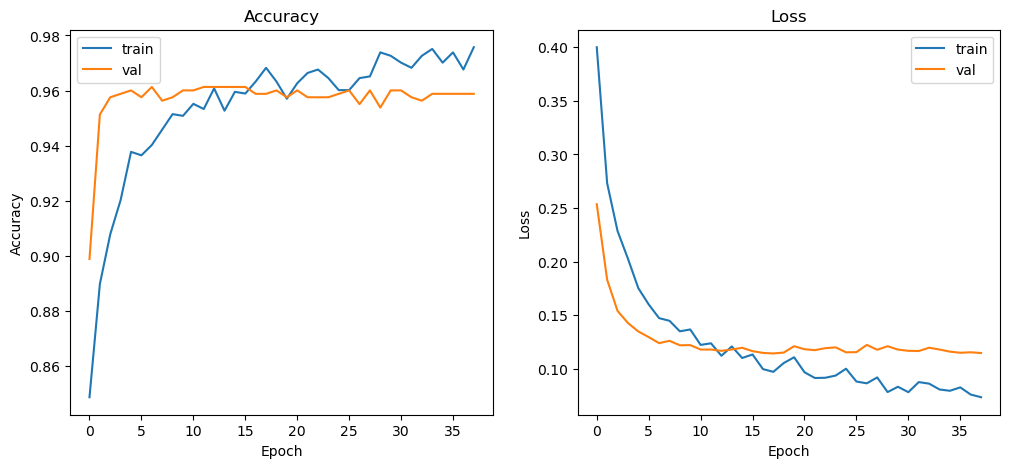

201/201 [==============================] - 5s 20ms/step

📊 Resultado por Classe:



,Tipo,Real,Previsto,Qtd
0,Acertou Amora,Amora,Amora,107
1,Errou Amora (não reconheceu),Amora,Not Amora,12
2,Achou que era Amora (mas não era),Not Amora,Amora,21
3,Acertou Not Amora,Not Amora,Not Amora,661



🐶 Reconhecimento da Amora: 89.92%


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# =========================
# 📈 GRÁFICOS
# =========================

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# =========================
# 🔮 PREDIÇÃO NO VALIDATION
# =========================

val_gen.reset()

y_prob = model.predict(val_gen)
y_pred = (y_prob > 0.5).astype(int).ravel()
y_true = val_gen.classes



# MATRIZ DE CONFUSÃO


cm = confusion_matrix(y_true, y_pred)

# 0 = AMORA
tp = cm[0,0]  # acertou Amora
fn = cm[0,1]  # era Amora e disse Not Amora
fp = cm[1,0]  # era Not Amora e disse Amora
tn = cm[1,1]  # acertou Not Amora

#table

tabela = pd.DataFrame({
    "Tipo": [
        "Acertou Amora",
        "Errou Amora (não reconheceu)",
        "Achou que era Amora (mas não era)",
        "Acertou Not Amora"
    ],
    "Real": [
        "Amora",
        "Amora",
        "Not Amora",
        "Not Amora"
    ],
    "Previsto": [
        "Amora",
        "Not Amora",
        "Amora",
        "Not Amora"
    ],
    "Qtd": [
        tp,
        fn,
        fp,
        tn
    ]
})

print("\n📊 Resultado por Classe:\n")
display(tabela)

recall_amora = tp / (tp + fn)

print(f"\n🐶 Reconhecimento da Amora: {recall_amora:.2%}")
